# MNIST digits generation with conditional DCGAN

We'll build a conditional variant of deep convolutional generative adversarial network (DCGAN) to generate user specified hand-written digits from the MNIST dataset.

## The MNIST dataset

The MNIST dataset consists of grayscale images of hand-written digits from 0 to 9. Each image is 28 pixels by 28 pixels. There're 60,000 training images and 10,000 test images.

We will download the dataset from the `torchvision` package of PyTorch. 

Before downloading the dataset, we will define transforms and normalization that we will apply to the dataset through `torchvision.transforms` module. The transforms we will apply are follows:

1. We will resize the images to 64x64.
2. We will normalize the pixel values to be between -1 and 1.    `

This is because the DCGAN models expects the images to be of size 64x64 and the pixel values to be between -1 and 1.

In [1]:
from torchvision import transforms

transform = transforms.Compose(
    [
        transforms.Resize((64, 64)), # Resize all images to 64x64
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5], inplace=True) # Normalize all images to [-1, 1]
    ]
)

We will apply the transforms created above to the training and test MNIST datasets.

The training and test datasets will be downloaded from the `torchvision.datasets` module, into the directory specified by the `root` argument. The `train` argument specifies whether to download the training or the test dataset by setting it to `True` or `False` respectively. Here, we will download the training dataset.

The `transform` argument specifies the transforms to be applied to the dataset. We will pass the transforms created above to this argument.

Set the `download` argument to `True` to download the dataset.

In [2]:
from torchvision import datasets

trainset = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)

We can now visualize some images from the training dataset using the `matplotlib` package.

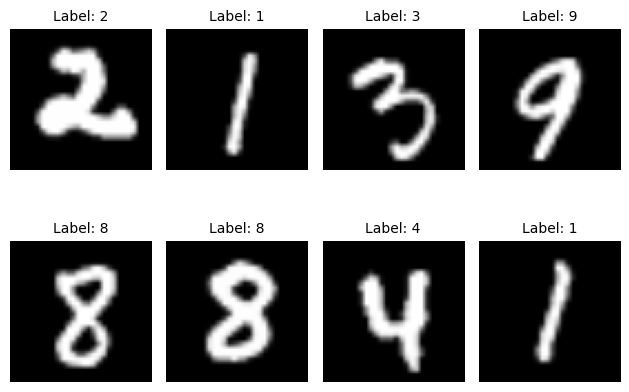

In [3]:
import torch
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4)
for i, ax in enumerate(axs.flatten()):
	img, label = trainset[torch.randint(0, len(trainset), (1,)).squeeze()] # randomly select an image from the training set
	ax.imshow(img.squeeze(), cmap="gray")
	ax.set_title(f"Label: {label}", fontsize=10)
	ax.axis("off")
plt.tight_layout()
plt.show()

We now define the `device` to be used for training the model. We will use the GPU if it's available, otherwise we will use the CPU. The `torch.cuda.is_available()` function returns `True` if the GPU is available, otherwise it returns `False`.

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Conditional DCGAN Generator and Discriminator

In this section we will define the generator and discriminator networks of the conditional DCGAN model.

### Generator
We use the class `DCGANGenerator` from `deeplay` to define the conditional variant of deep convolutional generator network. It takes a latent vector (noise vector) of size 100 as input, and class labels (Eg, 5 for digit 5) as input and outputs an image of size 64x64 specific to the class label.

The latent vector dimension is defined by the `latent_dim` parameter. Here, we set it to 100.

In order to use the conditional DCGAN model, the parameter `class_conditioned_model` is set to `True`.

Class labels are passed through a embedding layer to generate learnable class embedding vectors for each class. The dimension of the embedding vectors is defined by the `embedding_dim` parameter. Here, we set it to 100.

The number of classes is required to be passed to the `num_classes` parameter. Here, we set it to 10 as there are 10 classes in the MNIST dataset.

The remaining parameters are the same as the non-conditional DCGAN model.

The output channels of the image is defined by the `output_channels` parameter. Here, the `output_channels` parameter is set to 1 as the MNIST dataset consists of grayscale images.

The generator network consists of 4 upsampling layers (convolutional transpose layers). Each layer is followed by a batch normalization layer and a ReLU activation. The last layer is followed by a tanh activation. The number of convolutional filters in each of the 4 transposed convolutional layers is defined by the `features_dim` parameter which results in `[features_dim * 16, features_dim * 8, features_dim * 4, features_dim * 2]` filters in the first, second, third and fourth layers respectively.

Once we define the models, we will move them to the device defined above.

In [5]:
import deeplay as dl

generator = dl.DCGANGenerator(
    latent_dim=100,
    output_channels=1,
    features_dim=64,
    class_conditioned_model=True,
    embedding_dim=100,
    num_classes=10,
)
generator.build()

generator.to(device)

DCGANGenerator(
  (blocks): LayerList(
    (0): ConvTransposeBlock(
      (layer): ConvTranspose2d(200, 1024, kernel_size=(4, 4), stride=(1, 1))
      (activation): ReLU()
      (normalization): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ConvTransposeBlock(
      (layer): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): ReLU()
      (normalization): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ConvTransposeBlock(
      (layer): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): ReLU()
      (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ConvTransposeBlock(
      (layer): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): ReLU()
      (normalization): BatchNorm2d(128, eps=1e-05, m

### Discriminator
We use the class `DCGANDiscriminator` from `deeplay` to define a conditional variant of deep convolutional discriminator network. It takes an image of size 64x64, and class labels as input and outputs a single value between 0 and 1, indicating whether the input image is real or fake.

The input channels of the image is defined by the `input_channels` parameter. Here, the `input_channels` parameter is set to 1 as the MNIST dataset consists of gray scale images.

In order to use the conditional DCGAN model, the parameter `class_conditioned_model` is set to `True`.

Class labels are passed through a embedding layer to generate learnable class embedding vectors for each class. The dimension of the embedding vectors is defined by the `embedding_dim` parameter. Here, we set it to 100.

The number of classes is required to be passed to the `num_classes` parameter. Here, we set it to 10 as there are 10 classes in the MNIST dataset.

The remaining parameters are the same as the non-conditional DCGAN model.

The discriminator network consists of 4 layers of convolutional layers. Each layer is followed by a batch normalization layer and a LeakyReLU activation layer. The number of convolutional filter in each of these is defined by the `features_dim` parameter, resulting in `[features_dim, features_dim * 2, features_dim * 4, features_dim * 8]` filters in the first, second, third and fourth layers respectively.

Once we define the models, we will move them to the device defined above.

In [6]:
discriminator = dl.DCGANDiscriminator(
    input_channels=1,
    features_dim=64,
    class_conditioned_model=True,
    embedding_dim=100,
    num_classes=10,
)
discriminator.build()

discriminator.to(device)

DCGANDiscriminator(
  (blocks): LayerList(
    (0): ConvBlock(
      (layer): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
      (normalization): Identity()
    )
    (1): ConvBlock(
      (layer): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
      (normalization): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ConvBlock(
      (layer): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
      (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ConvBlock(
      (layer): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
      (normalization): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_runni

### Optimizers

We will define the optimizer and learning rates for the generator and discriminator networks. We will use the Adam optimizer with a learning rate of 0.0002 for both the generator and discriminator networks as defined by the `lr` parameter, and the coefficients `beta1` and `beta2` set to 0.5 and 0.999 respectively. The coefficients `beta1` and `beta2` are used for computing running averages of gradient and its square.

In [7]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

### Loss function

We define a loss function for the discriminator and generator.

In [8]:
criterion = torch.nn.BCELoss()  # Binary cross entropy loss

### Training data loader
We now define the data loader for the training dataset. We will use a batch size of 128 as defined by the `batch_size` parameter. We will also set the `shuffle` parameter to `True` to shuffle the training dataset before creating batches.

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

### Training procedure

We will now define the training loop for the DCGAN model for generating MNIST digits from noise. 

We will train the model for 20 epochs as defined by the `EPOCHS` parameter. 

The `BATCH_SIZE` parameter defines the batch size to be used for training the model. We will define it to the same value as the batch size used for creating the training data loader. 

The `LATENT_DIM` parameter defines the size of the latent vector (noise vector) to be used as input to the generator network. We will define it to the same value as the latent dimension used for defining the generator network.

If you over train it, it will mode collapse. You can notice it when the numbers generated for a particular digit are always of the same style.



Epoch 1/10
----------
Batch 1/469 : Generator Loss: 0.8613, Discriminator Loss: 0.6815
Batch 201/469 : Generator Loss: 1.6770, Discriminator Loss: 0.9810
Batch 401/469 : Generator Loss: 0.9127, Discriminator Loss: 0.6230
----------
Epoch 1/10 : Generator Loss: 1.9566, Discriminator Loss: 0.4282
Time taken: 0:00:13.817765


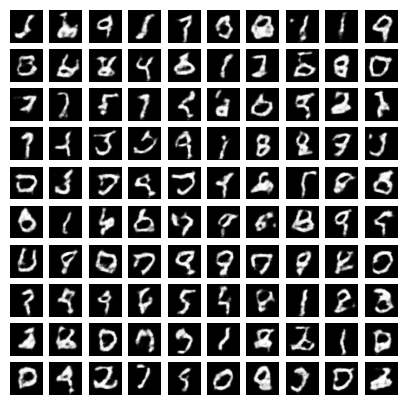



Epoch 2/10
----------
Batch 1/469 : Generator Loss: 0.8772, Discriminator Loss: 0.5391
Batch 201/469 : Generator Loss: 0.9532, Discriminator Loss: 0.5992
Batch 401/469 : Generator Loss: 1.5164, Discriminator Loss: 0.8543
----------
Epoch 2/10 : Generator Loss: 1.1052, Discriminator Loss: 0.5731
Time taken: 0:00:13.021278


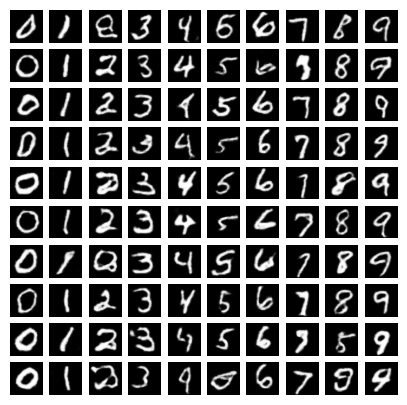



Epoch 3/10
----------
Batch 1/469 : Generator Loss: 0.7237, Discriminator Loss: 0.5589
Batch 201/469 : Generator Loss: 2.1652, Discriminator Loss: 0.5038
Batch 401/469 : Generator Loss: 1.3631, Discriminator Loss: 0.4765
----------
Epoch 3/10 : Generator Loss: 1.5474, Discriminator Loss: 0.4841
Time taken: 0:00:13.040309


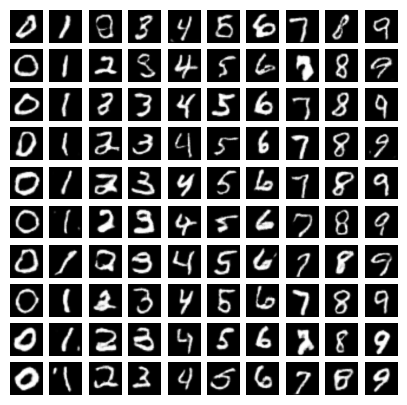



Epoch 4/10
----------
Batch 1/469 : Generator Loss: 1.6490, Discriminator Loss: 0.3908
Batch 201/469 : Generator Loss: 2.9755, Discriminator Loss: 0.2233
Batch 401/469 : Generator Loss: 2.7489, Discriminator Loss: 0.1062
----------
Epoch 4/10 : Generator Loss: 2.3434, Discriminator Loss: 0.2849
Time taken: 0:00:13.073397


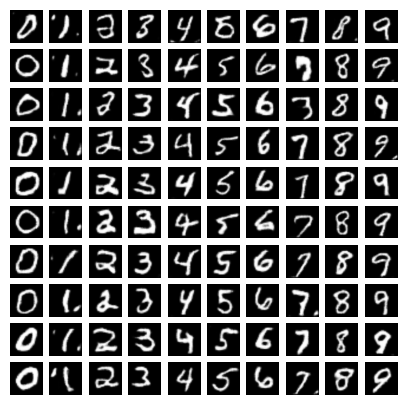



Epoch 5/10
----------
Batch 1/469 : Generator Loss: 3.5282, Discriminator Loss: 0.0647
Batch 201/469 : Generator Loss: 7.8059, Discriminator Loss: 0.6069
Batch 401/469 : Generator Loss: 3.6968, Discriminator Loss: 0.0657
----------
Epoch 5/10 : Generator Loss: 2.7878, Discriminator Loss: 0.2444
Time taken: 0:00:13.028319


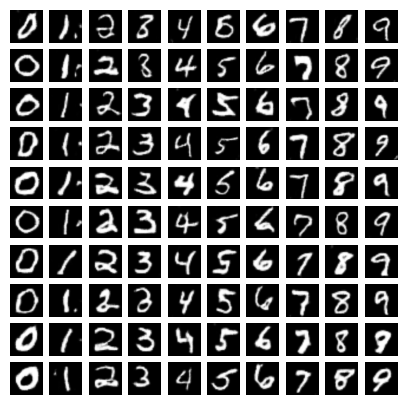



Epoch 6/10
----------
Batch 1/469 : Generator Loss: 3.0724, Discriminator Loss: 0.0630
Batch 201/469 : Generator Loss: 2.4169, Discriminator Loss: 0.1527
Batch 401/469 : Generator Loss: 3.8647, Discriminator Loss: 0.0229
----------
Epoch 6/10 : Generator Loss: 3.1986, Discriminator Loss: 0.1872
Time taken: 0:00:13.076115


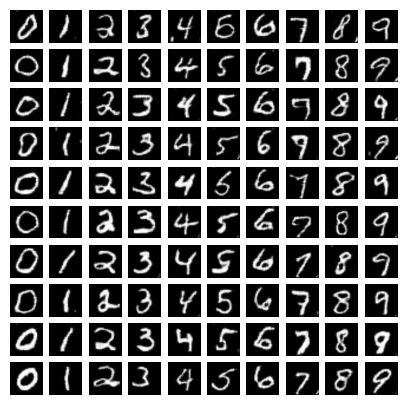



Epoch 7/10
----------
Batch 1/469 : Generator Loss: 0.8472, Discriminator Loss: 0.6776
Batch 201/469 : Generator Loss: 2.8607, Discriminator Loss: 0.0989
Batch 401/469 : Generator Loss: 1.5054, Discriminator Loss: 0.3030
----------
Epoch 7/10 : Generator Loss: 2.7427, Discriminator Loss: 0.2618
Time taken: 0:00:13.063842


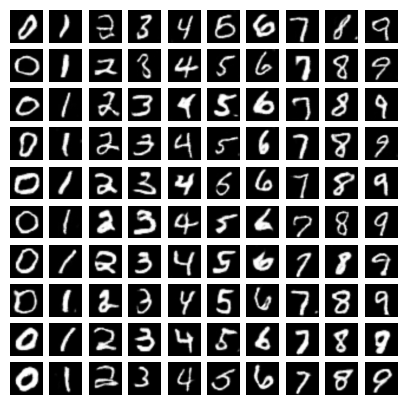



Epoch 8/10
----------
Batch 1/469 : Generator Loss: 3.7101, Discriminator Loss: 0.0907
Batch 201/469 : Generator Loss: 4.4752, Discriminator Loss: 0.0219
Batch 401/469 : Generator Loss: 2.6509, Discriminator Loss: 0.1346
----------
Epoch 8/10 : Generator Loss: 3.7810, Discriminator Loss: 0.1362
Time taken: 0:00:13.079075


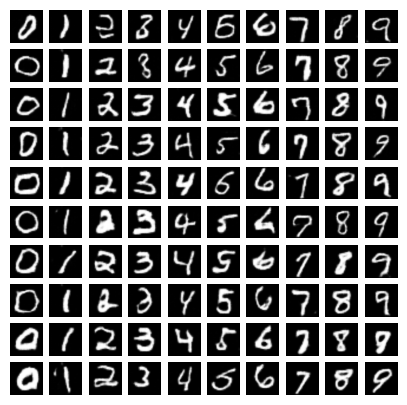



Epoch 9/10
----------
Batch 1/469 : Generator Loss: 3.8622, Discriminator Loss: 0.1559
Batch 201/469 : Generator Loss: 3.8425, Discriminator Loss: 0.0284
Batch 401/469 : Generator Loss: 5.0676, Discriminator Loss: 0.0145
----------
Epoch 9/10 : Generator Loss: 4.0558, Discriminator Loss: 0.0933
Time taken: 0:00:13.132297


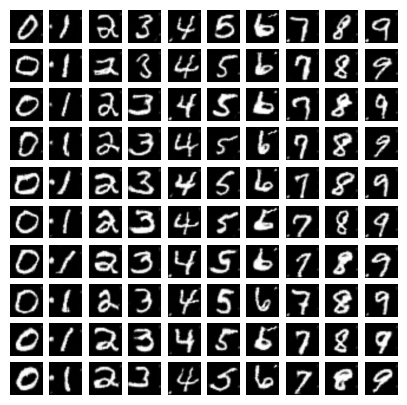



Epoch 10/10
----------
Batch 1/469 : Generator Loss: 4.8670, Discriminator Loss: 0.0099
Batch 201/469 : Generator Loss: 2.4929, Discriminator Loss: 0.1517
Batch 401/469 : Generator Loss: 4.0080, Discriminator Loss: 0.0404
----------
Epoch 10/10 : Generator Loss: 3.3034, Discriminator Loss: 0.2299
Time taken: 0:00:13.154055


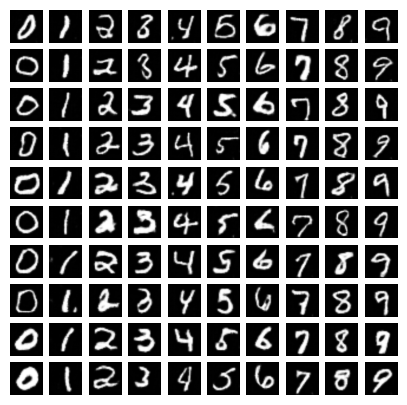

In [10]:
BATCH_SIZE = 128
LATENT_DIM = 100
EPOCHS = 10

# Import the packages required for checking the time taken for each epoch
import time
from datetime import timedelta

# Create empty lists to store the generator and discriminator losses for each epoch
gen_losses_avg = []
disc_losses_avg = []

# Create a fixed noise vector and fixed class labels of digits 0-9 to visualize the progression of the generator
fixed_latent_vector = torch.randn(100, LATENT_DIM, 1, 1).to(device)
fixed_class_labels = torch.arange(0, 10).repeat(10).to(device)

# Training loop
for epoch in range(EPOCHS):
    
    # Record the start time of each epoch
    start_time = time.time()

    num_batches = len(train_loader)

    print("\n")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print("-" * 10)

    running_generator_loss = 0.0
    running_discriminator_loss = 0.0

    generator.train()
    discriminator.train()

    for batch_idx, (real_image, class_labels) in enumerate(train_loader, start=0):
        real_image = real_image.to(device)
        class_labels = class_labels[..., None].to(device) # Add a channel dimension to the class labels

        corrected_batch_size = real_image.shape[0]

        noise = torch.randn(corrected_batch_size, LATENT_DIM, 1, 1).to(device)
        fake_image = generator(noise, class_labels)

        # 1.  Discriminator training (maximize log(D(x)) + log(1 - D(G(z))))

        # Discriminator outputs for real and fake images
        real_output = discriminator(real_image, class_labels).reshape(-1)
        fake_output = discriminator(fake_image, class_labels).reshape(-1)

        # Discriminator losses for real and fake images
        real_loss = criterion(real_output, torch.ones_like(real_output))
        fake_loss = criterion(fake_output, torch.zeros_like(fake_output))

        # Total discriminator loss
        discriminator_loss = (real_loss + fake_loss) / 2

        # Forward + Backward + Optimize (Discriminator)
        optimizer_D.zero_grad()
        discriminator_loss.backward(
            retain_graph=True
        )  # We will use the fake image again, so we need to retain the graph. Otherwise, the graph will be freed by PyTorch.
        optimizer_D.step()

        # 2.  Generator training (maximize log(D(G(z))))
        fake_output = discriminator(fake_image, class_labels).reshape(-1)
        generator_loss = criterion(fake_output, torch.ones_like(fake_output))

        # Forward + Backward + Optimize (Generator)
        optimizer_G.zero_grad()
        generator_loss.backward()
        optimizer_G.step()

        # Print the loss for this batch
        if batch_idx % 200 == 0:
            print(
                f"Batch {batch_idx+1}/{num_batches} : Generator Loss: {generator_loss.item():.4f}, Discriminator Loss: {discriminator_loss.item():.4f}"
            )

        running_generator_loss += generator_loss.item()
        running_discriminator_loss += discriminator_loss.item()

    # Store the loss for this epoch
    gen_losses_avg.append(running_generator_loss / num_batches)
    disc_losses_avg.append(running_discriminator_loss / num_batches)
    
    # Record the end time of each epoch
    end_time = time.time()

    # Print training statistics for this epoch (time taken, generator and discriminator losses)
    print("-" * 10)
    print(
        f"Epoch {epoch+1}/{EPOCHS} : Generator Loss: {gen_losses_avg[-1]:.4f}, Discriminator Loss: {disc_losses_avg[-1]:.4f}"
    )
    print(f"Time taken: {timedelta(seconds=end_time-start_time)}")

    # Set the generator and discriminator to eval mode to sample images from noise
    generator.eval()
    discriminator.eval()

    # Sample images from the 'fixed' latent vector
    fake_image = generator(fixed_latent_vector, fixed_class_labels).detach().cpu().numpy()

    # Plot sample images every epoch using matplotlib
    fig = plt.figure(figsize=(5, 5))
    for i in range(100):
        plt.subplot(10, 10, i + 1)
        plt.imshow(fake_image[i][0], cmap="gray")
        plt.axis("off")
    plt.show()

    # Close the figure to prevent memory leaks
    plt.close(fig)

### Sample images

We will now generate some sample images noise using the trained generator network. Re run the cell to generate new images. Change the class label to generate images of different classes.

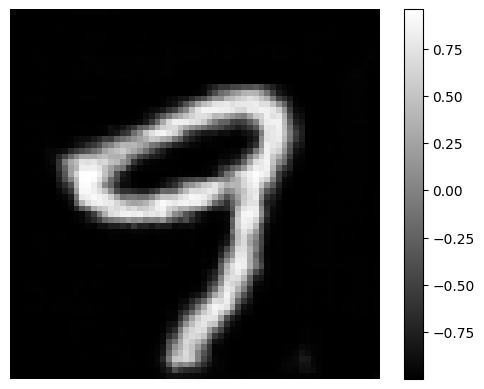

In [11]:
# Generate a random image from a random noise vector
generator.eval()

digit = 9
class_label = torch.Tensor([digit]).long().to(device)
noise = torch.randn(1, LATENT_DIM, 1, 1).to(device)

fake_image = generator(noise, class_label).detach().cpu().numpy()

plt.imshow(fake_image[0][0], cmap="gray")
plt.axis("off")
plt.colorbar()
plt.show()


### Plot losses

We will now plot the losses of the generator and discriminator networks during training.

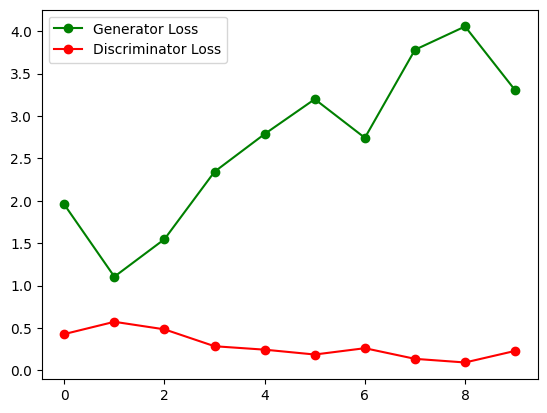

In [12]:
import numpy as np

plt.figure()
plt.plot(np.arange(len(gen_losses_avg)), gen_losses_avg, "g-o", label="Generator Loss")
plt.plot(
    np.arange(len(disc_losses_avg)), disc_losses_avg, "r-o", label="Discriminator Loss"
)
plt.legend()
plt.show()